## Words Analysis

This analysis examines collected text and meta-data from scientific articles that mention risk factors for violence and recidivism.

Available information includes the titles, words, and years of all those papers, enabling further exploration and analysis.


In [2]:
%matplotlib inline

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from lisc import Words
from lisc.data import ArticlesAll
from lisc.data.utils import threshold_counter, combine_lists
from lisc.utils import SCDB, load_object
from lisc.io import load_txt_file
from lisc.plts.words import plot_years, plot_wordcloud
from lisc.analysis.words import get_all_counts, get_all_values, get_attribute_counts

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
# Import custom project code
import sys
sys.path.append('../code')
from plts import plot_count_hist, plot_attrs_by_year

## Setup

In [5]:
# Settings
SAVE_FIG = True

In [22]:
# Set the file locations
term_dir = '../terms/'
figs_dir = '../data/figures/words'
import os
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
db = SCDB('../')

In [12]:
# Set the name of the file to load
name = 'riskfactors'

In [13]:
# Load the words object
words = load_object('words_' + name, directory=db, reload_results=True)

In [14]:
# Load exclusions for analysis
exclusions = load_txt_file('analysis_exclusions.txt', term_dir, split_elements=False)

### Check Database Information

Check the metadata about the data collection, including checking the database data were collected from.

In [15]:
# Check database scrape info
words.meta_data.db_info

{'dbname': 'pubmed',
 'menuname': 'PubMed',
 'description': 'PubMed bibliographic record',
 'dbbuild': 'Build-2025.02.07.23.14',
 'count': '38371236',
 'lastupdate': '2025/02/07 23:14'}

In [16]:
# Check requester object info
words.meta_data.requester

{'n_requests': 3146,
 'wait_time': 0.3333333333333333,
 'start_time': '16:22:35 Saturday 08 February 2025',
 'end_time': '18:07:00 Saturday 08 February 2025',
 'logging': None}

## Data Organization

In [17]:
# Process data to collapse across all articles
words.process_combined_results(exclusions=exclusions)

### Check Number of Articles

In [18]:
# Check the number of risk factors
print('Number of risk factors: 	 {}'.format(words.n_terms))

Number of risk factors: 	 59


In [19]:
# Check the total number of articles in the collected dataset
n_articles = [data.n_articles for data in words]
total_article_count = sum(n_articles)
print('Number of articles: \t', total_article_count)

Number of articles: 	 305694


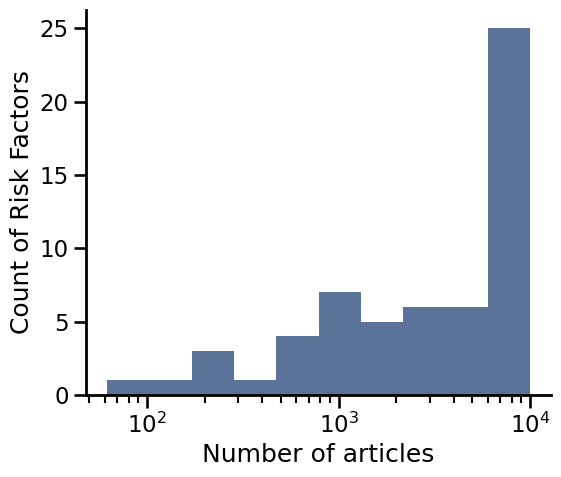

In [23]:
# Plot the histogram of the number of collected articles per risk factor
plot_count_hist(n_articles, log=True, bins=10,
                xlabel='Number of articles', ylabel='Count of Risk Factors',
                save_fig=SAVE_FIG, file_name='riskfactors_hist.pdf', directory=figs_dir)


In [27]:
# Collect all the DOIs across all papers, handling None values
all_dois = get_all_values(words, 'dois')
dois = [doi for sublist in all_dois if sublist is not None for doi in sublist]
dois = list(set(dois))  # Remove duplicates



In [28]:
# Check the number of unique papers, based on DOIs
print('Number of unique DOIs:', len(dois))

Number of unique DOIs: 6587


In [29]:
# Check how many articles were found per risk factor
for data in words.results:
    print(data.label, '\t', data.n_articles)

Single-parent family 	 232
Two-parent family 	 1207
Extended family 	 2220
Divorced parents 	 495
Stable family 	 545
Parental conflict 	 1223
Lack of supervision 	 712
Emotional support 	 9967
Family abuse 	 840
External abuse 	 9855
Low income 	 9975
Large family 	 7394
Antisocial thoughts 	 970
Moral reasoning 	 1873
Individualistic attitudes 	 4427
Prosocial attitudes 	 3105
Antisocial attitudes 	 139
Self-preservation beliefs 	 1589
Prosocial beliefs 	 852
Distorted beliefs 	 3350
Individualistic values 	 210
Prosocial values 	 9751
Antisocial values 	 2726
Hostility 	 9973
Anger states 	 9923
Criminal neighborhood 	 4326
Childhood violence 	 2865
Antisocial peers 	 3940
Debt 	 9970
Educational attainment 	 9979
Vocational skills 	 2078
Unemployment 	 9984
Work instability 	 1178
Prenatal tobacco exposure 	 3899
Prenatal alcohol exposure 	 1920
Prenatal drug exposure 	 698
Alcohol use 	 9959
Drug use 	 9948
Impulsivity 	 9982
Lack of empathy 	 1233
Dark traits 	 4349
Attachment st

## Check Attribute Counts

In [30]:
# Define a list of attributes to check
attrs = ['words', 'keywords', 'authors', 'journals', 'dois', 'titles', 'years']

In [31]:
# Check the proportion of papers, for each attribute, that has data
print('Attribute counts (total # articles: {}):'.format(total_article_count))
for attr in attrs:
    count = get_attribute_counts(words, attr)
    print('    {:5d} articles ({:6.2f} %) have {}.'.format(\
        count, count / total_article_count * 100, attr))

Attribute counts (total # articles: 305694):
    294173 articles ( 96.23 %) have words.
    192698 articles ( 63.04 %) have keywords.
    304491 articles ( 99.61 %) have authors.
    305694 articles (100.00 %) have journals.
    290175 articles ( 94.92 %) have dois.
    305694 articles (100.00 %) have titles.
    305694 articles (100.00 %) have years.


### Check Years of Publication

In [33]:
# Get global count of authors 
years = set(get_all_values(words, 'years'))
min_year, max_year = min(years), max(years)

In [34]:
# Print out summary of the year range of publications
print('Collected papers were published between the years: {}-{}'.format(min_year, max_year))

Collected papers were published between the years: 1885-2025


In [35]:
# Get the count of articles per year, and drop 2025 (incomplete year)
year_counts = get_all_counts(words, 'years', combine=True)
year_counts.pop(2025);

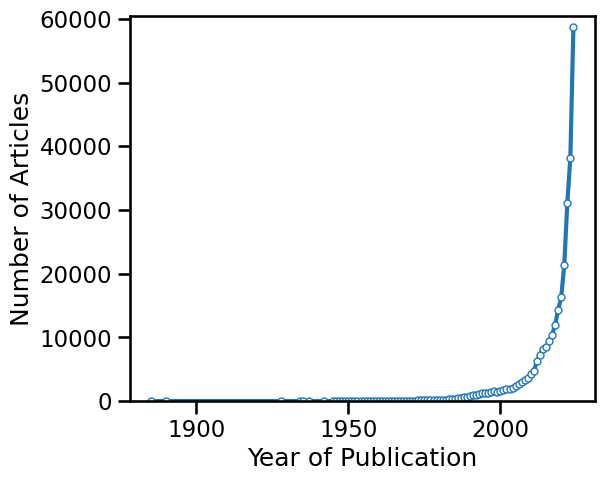

In [36]:
# Plot the total number of articles, across components, per year
plot_years(year_counts, figsize=(6, 5),
           save_fig=SAVE_FIG, file_name='words_year_counts.pdf', directory=figs_dir)

### Check number of distinct risk factors' studies per year

In [37]:
# Collect the set of years each risk factor was studied in
comp_years_all = {}
for label, res in zip(words.labels, words.results):
    comp_years_all[label] = set(res.years)

In [38]:
# Collect the number of unique components studied per year
comp_years = {}
for year in range(min(years), max(years)):
    count = 0
    for temp in comp_years_all.values():
        count += 1 if year in temp else 0
    comp_years[year] = count

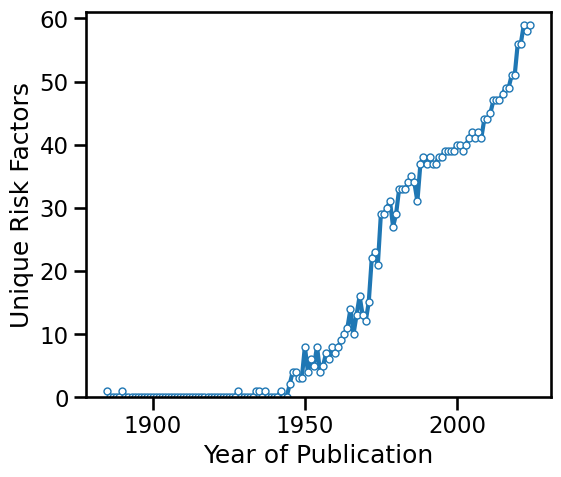

In [39]:
# Plot the number of unique components studied per year
plot_years(comp_years, ylabel='Unique Risk Factors', figsize=(6, 5),
           save_fig=SAVE_FIG, file_name='words_year_risk_factors.pdf', directory=figs_dir)

### Check Authors across all papers

In [40]:
# Get global count of authors 
author_counts = get_all_counts(words, 'authors', combine=True)

In [41]:
# Check the number of unique authors
print('Total number of authors   :\t {:5d}'.format(len(author_counts)))
print('Number of authors > 10   :\t {:5d}'.format(len(threshold_counter(author_counts, 10))))
print('Number of authors > 100  :\t {:5d}'.format(len(threshold_counter(author_counts, 100))))

Total number of authors   :	 623632
Number of authors > 10   :	 22467
Number of authors > 100  :	   539


In [42]:
# Check the most common authors
print('Most common authors:')
for (author, count) in author_counts.most_common(10):
    print('    {:15s} \t {}'.format(' '.join(author), count))

Most common authors:
    Wang Y          	 2007
    Zhang Y         	 1861
    Li Y            	 1653
    Wang X          	 1498
    Liu Y           	 1457
    Wang J          	 1427
    Li X            	 1292
    Li J            	 1281
    Zhang J         	 1160
    Zhang X         	 1110


### Check Journals across all papers

In [43]:
# Get global count of journals
journals_counts = get_all_counts(words, 'journals', combine=True)

In [44]:
# Check the number of unique authors
print('Total number of journals  :\t {:5d}'.format(len(journals_counts)))
print('Number of journals > 10   :\t {:5d}'.format(len(threshold_counter(journals_counts, 10))))
print('Number of journals > 100  :\t {:5d}'.format(len(threshold_counter(journals_counts, 100))))

Total number of journals  :	 11318
Number of journals > 10   :	  3996
Number of journals > 100  :	   600


In [45]:
# Check the most common journals
print('Most common journals:')
for (journal, count) in journals_counts.most_common(10):
    print('    {:55s} \t {}'.format(journal.split(':')[0], count))

Most common journals:
    PloS one                                                	 6002
    Frontiers in psychology                                 	 4542
    International journal of environmental research and public health 	 3799
    Frontiers in psychiatry                                 	 3119
    Scientific reports                                      	 2615
    Journal of affective disorders                          	 2407
    Cureus                                                  	 2117
    BMC public health                                       	 2096
    Psychiatry research                                     	 1957
    BMJ open                                                	 1713


### Keywords

In [46]:
# Get global count of authors 
kw_counts = get_all_counts(words, 'keywords', combine=True)

In [47]:
# Check the number of unique keywords
print('Total number of keywords   :\t {:5d}'.format(len(kw_counts)))
print('Number of keywords > 10    :\t {:5d}'.format(len(threshold_counter(kw_counts, 10))))
print('Number of keywords > 100   :\t {:5d}'.format(len(threshold_counter(kw_counts, 100))))

Total number of keywords   :	 218385
Number of keywords > 10    :	 11737
Number of keywords > 100   :	  1199


In [48]:
# Check the most common keywords across all components
print('Most common keywords:')
for (kw, count) in kw_counts.most_common(10):
    print('    {:20s} \t {}'.format(kw, count))

Most common keywords:
    mental health        	 8338
    covid-19             	 8133
    depression           	 7988
    anxiety              	 5103
    personality          	 4770
    adolescents          	 3327
    alcohol              	 2951
    borderline personality disorder 	 2841
    stress               	 2812
    adolescence          	 2563


In [ ]:
# Check most common keywords per risk factor
for data in words.combined_results:
    data.check_frequencies('keywords', n_check=5)

P100  : visual evoked potentials, visual evoked potential, n170, emotion, multiple sclerosis
P110  : 
P120  : phosphorus application, photosynthetic characteristics, population structure, uniform seeding pattern, winter wheat
P150  : aging, congenital hypothyroidism, iodine diet, psychiatric diseases, thyroid hormones
P160  : c1, higher-order cortical processing, perceptual learning, primary visual cortex
P170  : attention, hearing loss, neural mechanism, visual compensatory, dft
P180  : transcranial magnetic stimulation, tms-eeg, tms-evoked potentials, dorsolateral prefrontal cortex, schizophrenia
P190  : n/p190, n400, masked conceptual priming, masked repetition priming, visual object processing
P200  : n400, p300, n170, n100, attention
P220  : complexity, fraser spiral illusion, illusion, shape perception
P230  : confabulation, desynchronization, face recognition, memory schema, theta coherence
P240  : somatosensory cortex, touch, chinese three-character verb–object metaphor, contex

### Abstract Words

In [37]:
# Get global count of words 
word_counts = get_all_counts(words, 'words', combine=True)

In [38]:
# Check the number of unique words
print('Total number of words   :\t {:5d}'.format(len(word_counts)))
print('Number of words > 100   :\t {:5d}'.format(len(threshold_counter(word_counts, 100))))
print('Number of words > 1000  :\t {:5d}'.format(len(threshold_counter(word_counts, 1000))))

Total number of words   :	 88882
Number of words > 100   :	  4216
Number of words > 1000  :	   725


In [39]:
# Check the most common keywords across all components
print('Most common words:')
for (word, count) in word_counts.most_common(10):
    print('    {:20s} \t {}'.format(word, count))

Most common words:
    processing           	 26548
    patients             	 23560
    amplitude            	 20115
    study                	 19712
    task                 	 19309
    stimuli              	 19080
    results              	 18884
    visual               	 16143
    response             	 15525
    auditory             	 15182


In [40]:
# Check most common words
for data in words.combined_results:
    data.check_frequencies('words', n_check=5)

P100  : visual, patients, vep, latency, amplitude
P110  : visual, response, processing, children, components
P120  : stimuli, visual, p, components, ms
P150  : processing, visual, patients, early, components
P160  : interaction, binding, results, receptor, p
P170  : control, components, visual, cortex, ms
P180  : cortex, cortical, patients, subjects, ms
P190  : priming, recorded, cortex, area, repetition
P200  : patients, processing, p300, amplitude, n100
P220  : amplitude, de, components, sleep, stimulus
P230  : ms, components, differences, stimuli, visual
P240  : amplitude, stimuli, stimulus, components, processing
P250  : processing, components, patients, amplitude, task
P260  : pain, stimuli, components, processing, patients
P270  : stimuli, stimulus, stimulation, amplitude, components
P300  : patients, amplitude, study, latency, cognitive
P3a   : auditory, stimuli, p3b, patients, processing
P3b   : task, processing, stimuli, p3a, amplitude
P340  : pain, seps, patients, training, p

## Check Values by Year

In [41]:
# Extract lists of all values for attributes of interest
all_years = get_all_values(words, 'years')
all_journals = get_all_values(words, 'journals')
all_authors = get_all_values(words, 'authors')

In [42]:
# Collect the number of unique journals & authors by year
journals_by_year = {}
authors_by_year = {}
for year in range(min_year, max_year):
    inds = np.where(np.array(all_years) == year)[0]
    journals_by_year[year] = len(set(np.array(all_journals)[inds]))
    authors_by_year[year] = len(set(combine_lists([all_authors[ind] for ind in inds])))

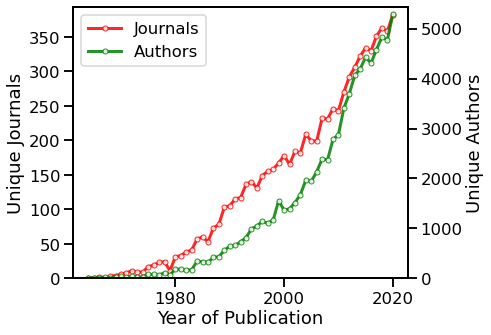

In [43]:
# Plot unique journals & authors by year
plot_attrs_by_year(journals_by_year, authors_by_year, figsize=(6, 5),
                   save_fig=SAVE_FIG, file_name='words_attr_year.pdf', directory=figs_dir)

## Example Component Summaries

In [44]:
# Set indices for some example components
inds = [15, 51]
print(words.labels[inds[0]], words.labels[inds[1]])

P300 N400


In [45]:
# Check some example summaries
for ind in inds:
    words.combined_results[ind].create_summary()
    words.combined_results[ind].print_summary()

P300 :
  Number of articles: 		 5839
  First publication: 		 1971
  Most common author: 		 Polich J
    number of publications: 	 116
  Most common journal: 		 Psychophysiology
    number of publications: 	 248 

N400 :
  Number of articles: 		 2594
  First publication: 		 1980
  Most common author: 		 Holcomb PJ
    number of publications: 	 91
  Most common journal: 		 Neuropsychologia
    number of publications: 	 217 



### WordCloud Plots

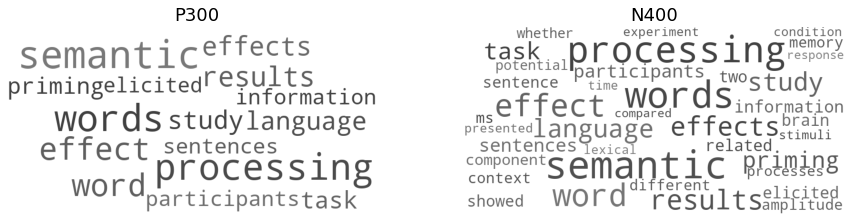

In [46]:
# Create wordclouds
_, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_wordcloud(words.combined_results[ind].words, inds[0], ax=axes[0])
axes[0].set_title(words.labels[inds[0]]);
plot_wordcloud(words.combined_results[ind].words, inds[1], ax=axes[1])
axes[1].set_title(words.labels[inds[1]]);

### History Plots

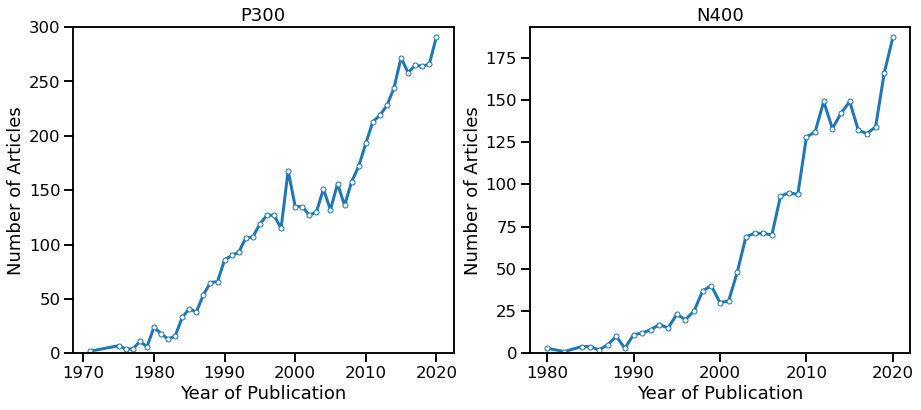

In [47]:
# Check an example history plot
_, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_years(words.combined_results[inds[0]].years, [None, 2020], ax=axes[0])
axes[0].set_title(words.labels[inds[0]]);
plot_years(words.combined_results[inds[1]].years, [None, 2020], ax=axes[1])
axes[1].set_title(words.labels[inds[1]]);